# Predicting success of Kickstarter projects
### Eynat Grof

Data from: <br>
https://www.kaggle.com/kemical/kickstarter-projects/downloads/kickstarter-projects.zip/7

In [116]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import linear_kernel
from sklearn.linear_model import LogisticRegression
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load and clean the data

In [4]:
col_names = ['id', 'name', 'sub_category', 'main_category', 'currency',
             'deadline', 'goal', 'launched', 'pledged', 'state', 'backers',
             'country', 'usd_pledged', 'usd_pledged_real', 'usd_goal_real']
data = pd.read_csv('ks_projects_201801.csv', names = col_names, low_memory=False, skiprows=[0])
print(len(data))
data.head()

378661


,id,name,sub_category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Drop NAs

In [5]:
# is.null is robust enough even with mixed data types
data.isnull().sum()

id                     0
name                   4
sub_category           0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [6]:
observations = len(data)
print('BEFORE DROPPING NA\'S:')
print('There are', observations, 'kickstarter projects in the dataset.')
data = data.dropna()
print('AFTER DROPPING NA\'S:')
print('There are', len(data), 'kickstarter projects in the dataset.', observations-len(data), 'projects were dropped.')

BEFORE DROPPING NA'S:
There are 378661 kickstarter projects in the dataset.
AFTER DROPPING NA'S:
There are 374860 kickstarter projects in the dataset. 3801 projects were dropped.


### Handle column data types

In [7]:
# make sure each column is the right type, so it is easier to work with later
data['name'] = data.name.astype(str)
data['sub_category'] = data.sub_category.astype(str)
data['main_category'] = data.main_category.astype(str)
data['currency'] = data.currency.astype(str)
data['deadline'] = data.deadline.astype('datetime64[ns]')
data['launched'] = data.launched.astype('datetime64[ns]')
data['state'] = data.state.astype(str)
data['country'] = data.country.astype(str)


In [8]:
data.dtypes

id                           int64
name                        object
sub_category                object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd_pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

# Feature engineering

### Add campaign duration feature

In [16]:
# calculating duration by looking at the date a project launched, and deadline
data['duration'] = data.deadline - data.launched
for i in range(len(data)):
    value = data.iloc[i, 15]
    data.iloc[i, 15] = value.days
    print('%d out of %d' %(i,len(data)), end = '\r')

### Add day of the week, and month a project launched in feature

In [17]:
# from the date object, extract the correct day of week and month
data['day_of_week'] = data['launched'].dt.dayofweek
data['month'] = data['launched'].dt.month

### Create proper label variable
**so it can be used with the classifier**

In [18]:
data['state'].value_counts()

failed        197611
successful    133851
canceled       38757
live            2798
suspended       1843
Name: state, dtype: int64

In [19]:
# drop all unfinsished projects
data.drop(data.loc[data['state']== 'live'].index, inplace=True)
data.drop(data.loc[data['state']== 'suspended'].index, inplace=True)
data.drop(data.loc[data['state']== 'canceled'].index, inplace=True)

In [20]:
print('number of projects:', len(data))
data['state'].value_counts()

number of projects: 331462


failed        197611
successful    133851
Name: state, dtype: int64

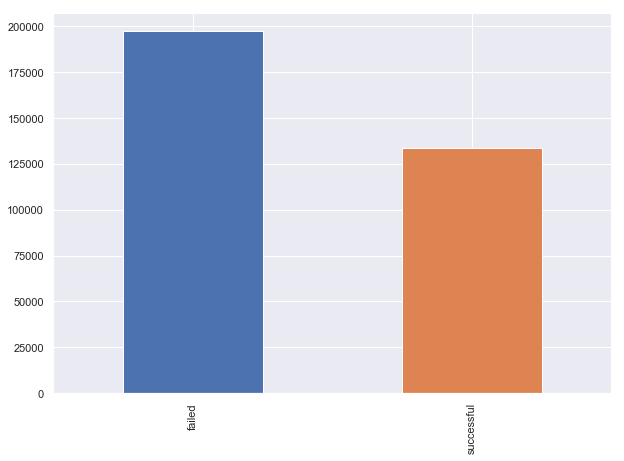

In [113]:
# visualize the balance between classes
data['state'].value_counts().plot(kind='bar', figsize = (10,7))

In [21]:
# convert label to binary (as most ML classifiers expact)
dummies = pd.get_dummies(data['state'])
dummies.head()

,failed,successful
0,1,0
1,1,0
2,1,0
3,1,0
5,0,1


In [22]:
data = pd.concat([data, dummies], axis=1)

In [23]:
data.to_csv('out.csv')

### Encode all feature/label variables and combine into one data frame

In [10]:
clf_data = pd.DataFrame(data['id'].values, columns = ['id'])

In [11]:
# create a dataset that can be used with the classifier, where all variables
# are encoded (so no strings or date onjects)
lb_make = LabelEncoder()
clf_data['main_category'] = lb_make.fit_transform(data["main_category"])
clf_data['sub_category'] = lb_make.fit_transform(data["sub_category"])
clf_data['currency'] = lb_make.fit_transform(data["currency"])
clf_data['country'] = lb_make.fit_transform(data["main_category"])

clf_data['duration'] = data['duration']
clf_data['day_of_week'] = data['day_of_week']
clf_data['month'] = data['month']
clf_data['backers'] = data['backers']
clf_data['usd_goal_real'] = data['usd_goal_real']
clf_data['usd_pledged_real'] = data['usd_pledged_real']
clf_data['label'] = data['successful']

In [12]:
clf_data.head()

,id,main_category,sub_category,currency,country,duration,day_of_week,month,backers,usd_goal_real,usd_pledged_real,label
0,1000002330,12,108,5,12,58,1,8,0,1533.95,0.0,0
1,1000003930,6,93,13,6,59,5,9,15,30000.00,2421.0,0
2,1000004038,6,93,13,6,44,5,1,3,45000.00,220.0,0
3,1000007540,10,90,13,10,29,5,3,1,5000.00,1.0,0
4,1000014025,7,123,13,7,34,4,2,224,50000.00,52375.0,1


# Split to test and train set

In [15]:
# split to test and train test
split = np.random.rand(len(clf_data)) < 0.8

train = clf_data[split]
test = clf_data[~split]
print('Projects in training set:', len(train))
print('Projects in test set:', len(test))

X_train = train.drop(['label'], axis=1)
y_train = train.loc[:,'label']
X_test = test.drop(['label'], axis=1)
y_test = test.loc[:,'label']
print('X train shape:', X_train.shape, type(X_train))
print('y_train shape:', y_train.shape, type(y_train))
print('X_test shape:', X_test.shape, type(X_test))
print('y_test shape:', y_test.shape, type(y_test))

#convert to arrays
X_train = pd.DataFrame.as_matrix(X_train)
X_test = pd.DataFrame.as_matrix(X_test)

Projects in training set: 265285
Projects in test set: 66177
X train shape: (265285, 11) <class 'pandas.core.frame.DataFrame'>
y_train shape: (265285,) <class 'pandas.core.series.Series'>
X_test shape: (66177, 11) <class 'pandas.core.frame.DataFrame'>
y_test shape: (66177,) <class 'pandas.core.series.Series'>


# Train logistic regression

In [52]:
# create model object and train and train set
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
# predict and present results
score = logreg.score(X_test, y_test)
predictions = logreg.predict(X_test)
matrix = metrics.confusion_matrix(y_test, predictions)
print('ACC scroe:', score)
print(matrix)

ACC scroe: 0.6488054762228569
[[39473     3]
 [23238  3463]]


# Improve by doing grid search

In [100]:
# perform grid search to optimize parameters
def logreg_param_selection(X, y, nfolds):
    Cs = [0.0001, 0.001, 0.01, 1, 10]
    penalty = ['l1', 'l2']
    param_grid = {'C': Cs, 'penalty': penalty}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=nfolds,
                              verbose = 10, n_jobs = -1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [101]:
logreg_param_selection(X_train, y_train, 3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.0001, penalty=l1 ............................................
[CV] C=0.0001, penalty=l1 ............................................
[CV] C=0.0001, penalty=l1 ............................................
[CV] C=0.0001, penalty=l2 ............................................
[CV] C=0.0001, penalty=l2 ............................................
[CV] C=0.0001, penalty=l2 ............................................
[CV] C=0.001, penalty=l1 .............................................
[CV] C=0.001, penalty=l1 .............................................
[CV] .... C=0.0001, penalty=l2, score=0.632824073550532, total=   2.3s
[CV] C=0.001, penalty=l1 .............................................
[CV] .... C=0.0001, penalty=l2, score=0.618962534067649, total=   2.2s
[CV] ... C=0.0001, penalty=l2, score=0.6521503126802294, total=   2.3s
[CV] C=0.001, penalty=l2 .............................................
[CV] C=0.001, pe

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s


[CV] ..... C=0.001, penalty=l2, score=0.632824073550532, total=   1.8s
[CV] .... C=0.001, penalty=l2, score=0.6521503126802294, total=   1.7s
[CV] C=0.001, penalty=l2 .............................................
[CV] C=0.01, penalty=l1 ..............................................
[CV] ..... C=0.001, penalty=l2, score=0.618962534067649, total=   1.6s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ... C=0.0001, penalty=l1, score=0.7073179006412069, total=  30.3s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ... C=0.0001, penalty=l1, score=0.7102873491727827, total=  31.0s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ...... C=0.01, penalty=l2, score=0.632824073550532, total=   1.8s
[CV] C=0.01, penalty=l2 ..............................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.3s


[CV] .... C=0.001, penalty=l1, score=0.6955410555360798, total=  33.0s
[CV] C=0.01, penalty=l2 ..............................................
[CV] .... C=0.001, penalty=l1, score=0.7143810288480024, total=  33.3s
[CV] C=1, penalty=l1 .................................................
[CV] ... C=0.0001, penalty=l1, score=0.6994311820782775, total=  34.3s
[CV] C=1, penalty=l1 .................................................
[CV] ..... C=0.01, penalty=l2, score=0.6521503126802294, total=   2.0s
[CV] C=1, penalty=l1 .................................................
[CV] ...... C=0.01, penalty=l2, score=0.618962534067649, total=   2.0s
[CV] C=1, penalty=l2 .................................................
[CV] ......... C=1, penalty=l2, score=0.632824073550532, total=   2.0s
[CV] C=1, penalty=l2 .................................................
[CV] ........ C=1, penalty=l2, score=0.6521503126802294, total=   1.7s
[CV] C=1, penalty=l2 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   44.8s remaining:   25.9s


[CV] .... C=0.001, penalty=l1, score=0.6987006231128502, total= 1.0min
[CV] C=10, penalty=l2 ................................................
[CV] ........ C=10, penalty=l2, score=0.632824073550532, total=   2.7s
[CV] C=10, penalty=l2 ................................................
[CV] ....... C=10, penalty=l2, score=0.6521503126802294, total=   2.4s
[CV] C=10, penalty=l2 ................................................
[CV] ........ C=1, penalty=l1, score=0.7243438238586889, total=  36.0s


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.2min remaining:   21.6s


[CV] ........ C=10, penalty=l2, score=0.618962534067649, total=   2.2s
[CV] ........ C=1, penalty=l1, score=0.6983726689811935, total=  39.8s
[CV] ...... C=0.01, penalty=l1, score=0.697671525665238, total=  51.8s
[CV] ........ C=1, penalty=l1, score=0.7004715647581675, total=  49.3s


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.4min remaining:    9.3s


[CV] ....... C=10, penalty=l1, score=0.6943536622601183, total= 7.8min
[CV] ....... C=10, penalty=l1, score=0.7323276300761062, total= 7.8min
[CV] ....... C=10, penalty=l1, score=0.6991077385866308, total= 7.8min


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.6min finished


{'C': 10, 'penalty': 'l1'}

In [103]:
# create a new model object and train with new parameters
logreg_tuned = LogisticRegression(C = 10, penalty = 'l1')
logreg_tuned.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
# predict and present results
score_tuned = logreg_tuned.score(X_test, y_test)

predictions_tuned = logreg_tuned.predict(X_test)
matrix = metrics.confusion_matrix(y_test, predictions_tuned)
report = metrics.classification_report(y_test, predictions_tuned)

print('ACC score:', score_tuned)
print(report)
print(matrix)

ACC score: 0.6932015654985871
             precision    recall  f1-score   support

          0       0.66      0.99      0.79     39476
          1       0.94      0.26      0.40     26701

avg / total       0.77      0.69      0.64     66177

[[39035   441]
 [19862  6839]]
